# Import Libraries

Here are some essential libraries required to initialize and analyze a fake news detection system.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import Dataset

Import the dataset file in the below section.

In [2]:
data = pd.read_csv('/content/News.csv',index_col=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Feature Avilable

These lines will help you gather necessary information about the dataset after importing it, allowing you to understand its structure, summary statistics, missing values, and provide a quick view of the dataset with necessaary data.

In [3]:
data.shape

(44919, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44919 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44919 non-null  object
 1   text     44919 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44919 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [5]:
data = data.drop(["title", "subject","date"], axis = 1)

In [6]:
data.isnull().sum()

,0
text,0
class,0


In [7]:
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

In [8]:
data.head()

,text,class
0,The Obama administration s well guarded Osama ...,0
1,"At this point in the election, Republican fron...",0
2,After the horrific attacks that claimed 50 liv...,0
3,Democratic presidential nominee Hillary Clinto...,0
4,PHNOM PENH (Reuters) - Cambodia could make mor...,1


# Visualize the Fake and Real News

To gain a clearer understanding of the dataset, we visualize the distribution of fake and real news using a pie chart.

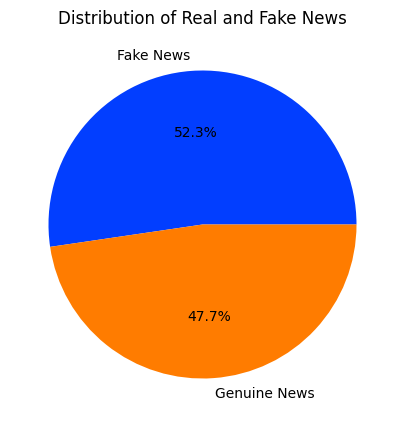

In [9]:
colors = sns.color_palette('bright')

plt.figure(figsize=(19, 5))
plt.pie(x=data["class"].value_counts().values, labels=["Fake News", "Genuine News"], colors=colors, autopct='%1.1f%%')
plt.title('Distribution of Real and Fake News')
plt.show()

# Text Preprocessing

Raw textual data often requires extensive preprocessing before it can be utilized for building any machine learning model. Key steps in this process for this fake news detection system include removing punctuation and numbers, converting text to lowercase, and removing stopwords. These techniques are crucial for transforming unrefined text into a structured format that is ready for analysis or model development. By cleaning and standardizing the text, we can ensure that the model focuses on meaningful patterns and reduces noise from irrelevant words and characters.

In [10]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

In [13]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [29:12<00:00, 25.64it/s]


In [14]:
def wordoption(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\n', '', text)
    return text

In [15]:
data['text'] = data['text'].apply(wordoption)
data['text']

,text
0,the obama administration well guarded osama bi...
1,at point election republican front runner dona...
2,after horrific attacks claimed lives wounded ...
3,democratic presidential nominee hillary clinto...
4,phnom penh reuters cambodia could make arrests...
...,...
44914,washington reuters hurricane harvey devastated...
44915,washington reuters tom price sworn us secretar...
44916,brussels reuters the european union cut back c...
44917,reuters banks financial companies expecting bi...


# Word Cloud

I was curious about which words are most often used in the fake news dataset. Could we create a Word Cloud out of all the text?

Word cloud for the real news

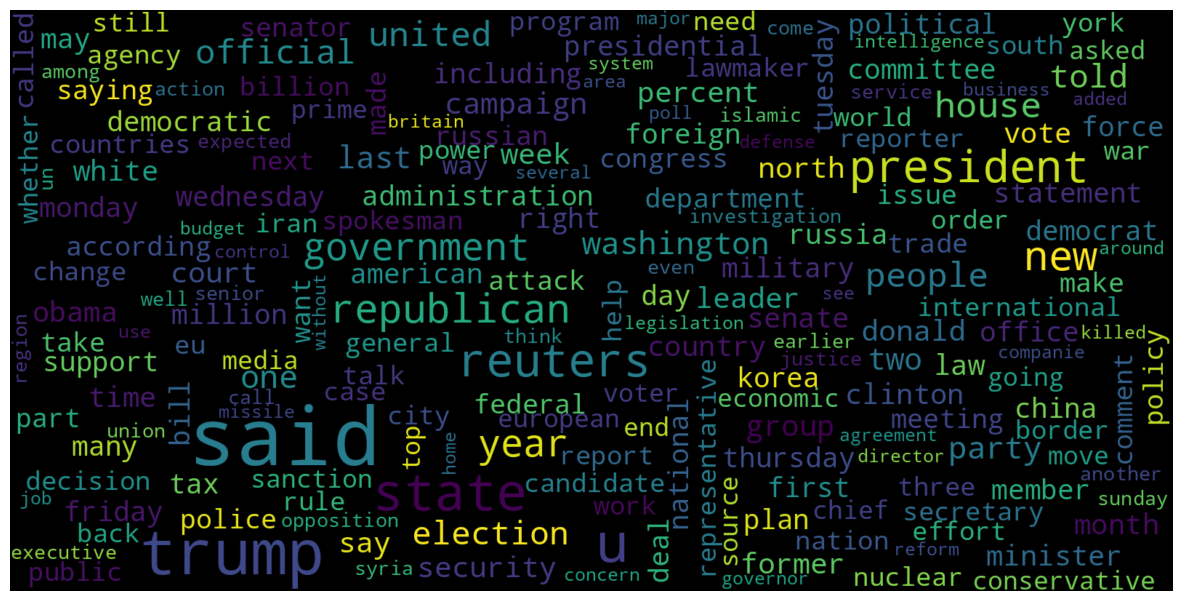

In [16]:
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

Word cloud for the fake news.

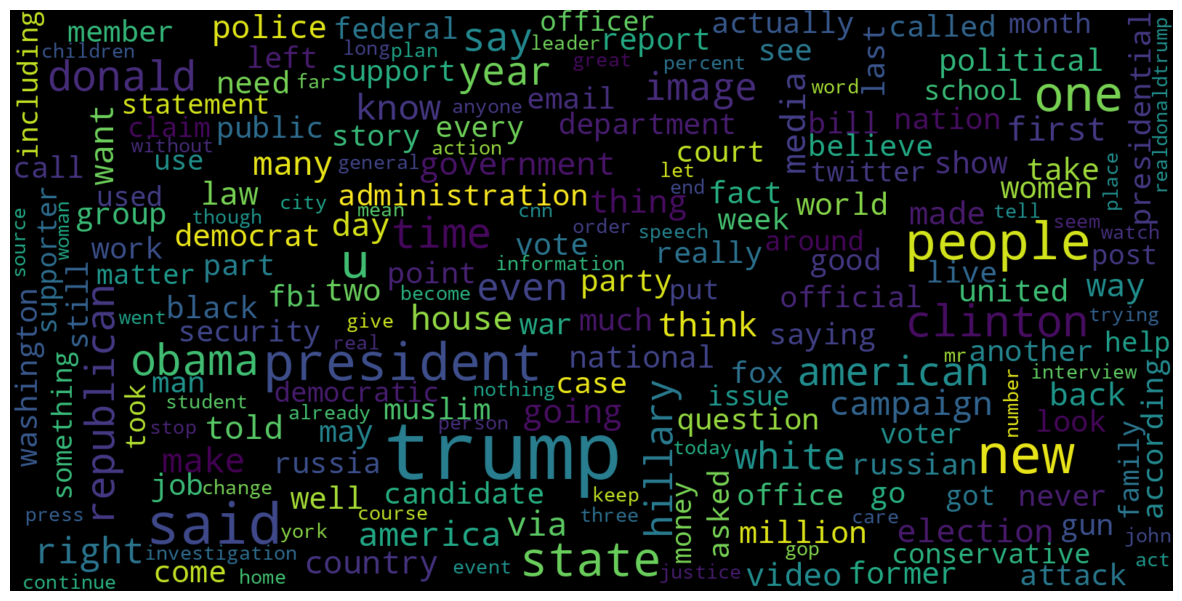

In [17]:
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

# Visualize Most Frequently Useable Word

Here, we aim to identify the most frequently used words in the dataset. However, this creates some challenges in distinguishing fake news from real news, as many words overlap between the two categories.

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

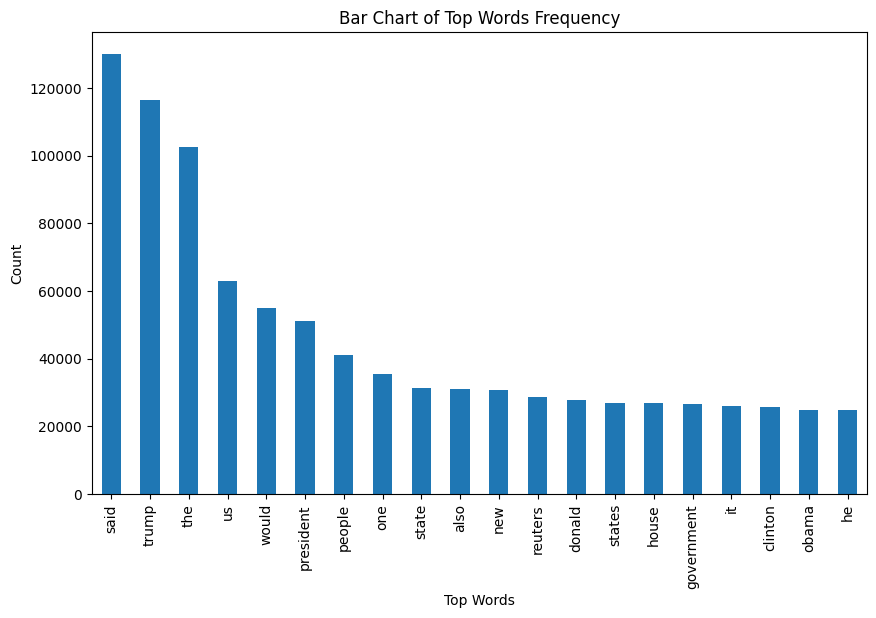

In [18]:
def get_top_n_words(corpus, n=None):
	vec = CountVectorizer().fit(corpus)
	bag_of_words = vec.transform(corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)

# Analyze The Accuracy

We analyze the dataset using different machine learning algorithms to identify the best-performing one, which will then be applied in the next stage for building the recommendation system.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data['text'],
													data['class'],
													test_size=0.33)

In [20]:
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [21]:
model1 = LogisticRegression()
model1.fit(x_train, y_train)

print(accuracy_score(y_train, model1.predict(x_train)))
print(accuracy_score(y_test, model1.predict(x_test)))

0.9935537464695132
0.9897463572584997


In [22]:
model2 = GradientBoostingClassifier()
model2.fit(x_train, y_train)

print(accuracy_score(y_train, model2.predict(x_train)))
print(accuracy_score(y_test, model2.predict(x_test)))

0.9966107326798471
0.9951430113329736


In [23]:
model3 = RandomForestClassifier()
model3.fit(x_train, y_train)

print(accuracy_score(y_train, model3.predict(x_train)))
print(accuracy_score(y_test, model3.predict(x_test)))

1.0
0.9919050188882893


In [24]:
model4 = XGBClassifier()
model4.fit(x_train, y_train)

print(accuracy_score(y_train, model4.predict(x_train)))
print(accuracy_score(y_test, model4.predict(x_test)))

1.0
0.9973016729627631


In [25]:
accuracy_scores = {
    "Logistic Regression": accuracy_score(y_test, model1.predict(x_test)),
    "Gradient Boosting": accuracy_score(y_test, model2.predict(x_test)),
    "Random Forest": accuracy_score(y_test, model3.predict(x_test)),
    "XGBoost": accuracy_score(y_test, model4.predict(x_test))
}

best_model = max(accuracy_scores, key=accuracy_scores.get)
best_accuracy = accuracy_scores[best_model]

print(f"The model with the best accuracy is {best_model} with an accuracy of {best_accuracy:.4f}")

The model with the best accuracy is XGBoost with an accuracy of 0.9973


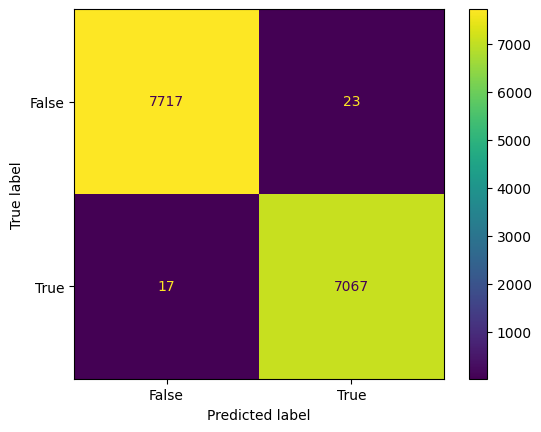

In [26]:
cm = metrics.confusion_matrix(y_test, model4.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()

In [27]:
print("Classification Report for XGBoost:", classification_report(y_test, model4.predict(x_test)))

Classification Report for XGBoost:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7740
           1       1.00      1.00      1.00      7084

    accuracy                           1.00     14824
   macro avg       1.00      1.00      1.00     14824
weighted avg       1.00      1.00      1.00     14824



# Detection System

Finally, we can develop a fake news detection system. By utilizing the trained model, we can input a news article and predict whether it is genuine or fake.

In [28]:
def output_label(n):
    if n==0:
        return "Fake News"
    else:
        return "Genuine News"

In [29]:
def manual_testing(news):
    testing_news = {"text": [news]}
    new_df_test = pd.DataFrame(testing_news)

    new_df_test["text"] = new_df_test["text"].apply(wordoption)
    new_x_test = new_df_test["text"]

    new_xv_test = vectorization.transform(new_x_test)

    pred_xgb = model4.predict(new_xv_test)

    result = (
        f"XGBClassifier Prediction: {output_label(pred_xgb[0])}"
    )

    return result

In [37]:
news_article = input("Enter a news text to predict if it's Genuine or Fake: ")
print("\nFAKE NEWS DETECTION")
print(manual_testing(news_article))

Enter a news text to predict if it's Genuine or Fake: washington reuters tom price

FAKE NEWS DETECTION
XGBClassifier Prediction: Genuine News
